### References
https://github.com/uber/h3-py-notebooks/blob/master/notebooks/urban_analytics.ipynb  
https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb

In [165]:
from folium import Map, Marker, GeoJson
from folium.plugins import MarkerCluster
import branca.colormap as cm
from branca.colormap import linear
import folium
from folium import plugins
import h3
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

In [166]:
import sys
sys.path.append("./src")

from service.secrets import SecretsService
from service.s3_client import S3ClientService
from repository.h3 import H3Repository, H3Source
from repository.service_request import ServiceRequestRepository, SRSource
from repository.cache import PoormansLocalFileCache
from repository.winddata import WindDataRepository

REGION = 'af-south-1'
BUCKET_NAME = 'cct-ds-code-challenge-input-data'
CACHE_DIR = './cache'

s3_client_service = S3ClientService(REGION, SecretsService())
repo_cache = PoormansLocalFileCache(CACHE_DIR)
h3_repo = H3Repository(BUCKET_NAME, s3_client_service, repo_cache)
sr_repo = ServiceRequestRepository(BUCKET_NAME, s3_client_service, repo_cache)
wd_repo = WindDataRepository()

# 2. Initial Data Transformation 

In [167]:
# Load the provided level 8 H3 polygons and the service request data
df_sr = sr_repo.get_request_entries(SRSource.UNJOINED)
df_sr_spec = sr_repo.get_request_entries(SRSource.JOINED)
gdf_l8_given = h3_repo.query_features(H3Source.LEVEL_8_ONLY)

In [168]:
gdf_l8_given.head()

,index,centroid_lat,centroid_lon,geometry
0,88ad361801fffff,-33.859427,18.677843,"POLYGON ((18.68119 -33.86330, 18.68357 -33.859..."
1,88ad361803fffff,-33.855696,18.668766,"POLYGON ((18.67211 -33.85957, 18.67450 -33.855..."
2,88ad361805fffff,-33.855263,18.685959,"POLYGON ((18.68931 -33.85914, 18.69169 -33.855..."
3,88ad361807fffff,-33.851532,18.676881,"POLYGON ((18.68023 -33.85541, 18.68261 -33.851..."
4,88ad361809fffff,-33.867322,18.678806,"POLYGON ((18.68215 -33.87120, 18.68454 -33.867..."


<Axes: xlabel='longitude', ylabel='latitude'>

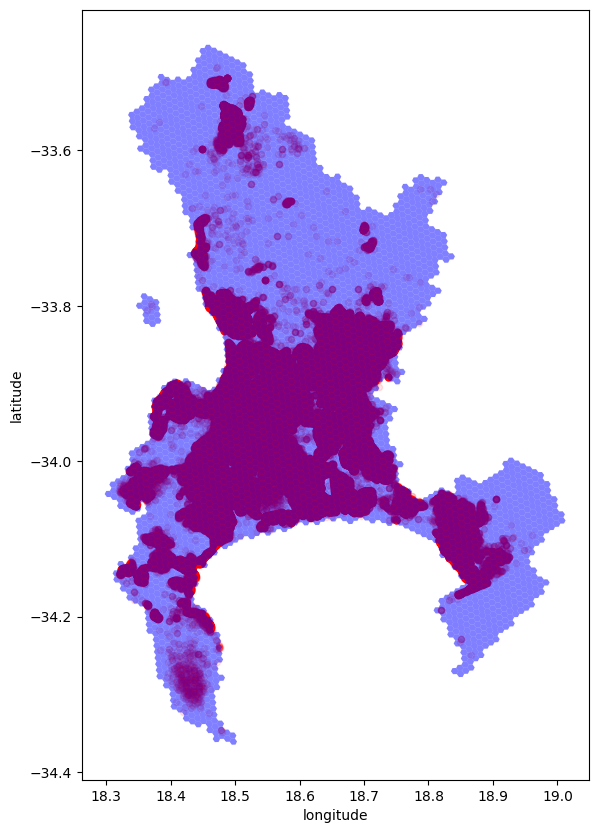

In [169]:
# Plot the points under the polygons with some transparency to visually inspect the overlap for correctness.
fig, ax = plt.subplots(figsize=(10, 10))
df_sr.plot(ax=ax, x="longitude", y="latitude", kind="scatter", alpha=0.1, color="red")
gdf_l8_given.plot(ax=ax, color="blue", alpha=0.5)

From the above we can see the overlap looks good. There are however some edge-cases that are difficult to check like this. The next step aims to resolve this. We can aggregate the service requests by hexagon (to reduce the size) and then plot the centroids of the hexagons over the polygons to see if they are in the correct location.

In [170]:
# Add the H3 hexagon column to the service request data (level 8 and 9 for later use)
RESOLUTION_LEVEL = 8
SUB_RESOLUTION_LEVEL = 9
hex_col = 'h3_hex'+str(RESOLUTION_LEVEL)
df_sr[hex_col] = df_sr.apply(lambda x: h3.geo_to_h3(x["latitude"], x["longitude"], RESOLUTION_LEVEL), axis=1)
sub_hex_col = 'h3_hex'+str(SUB_RESOLUTION_LEVEL)
df_sr[sub_hex_col] = df_sr.apply(lambda x: h3.geo_to_h3(x["latitude"], x["longitude"], SUB_RESOLUTION_LEVEL), axis=1)

In [171]:
df_sr = df_sr[df_sr[hex_col] != '0'].copy()
df_sr['h3_lat'] = df_sr[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_sr['h3_lng'] = df_sr[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# Aggregate service requests by hexagon
df_srg = df_sr.groupby(hex_col).size().to_frame('cnt').reset_index()
df_srg['latitude'] = df_srg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_srg['longitude'] = df_srg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# Create the geodataframe for the aggregated service requests
gdf_srg = gpd.GeoDataFrame(
    df_srg, geometry=gpd.points_from_xy(df_srg['longitude'], df_srg['latitude']))

<Axes: >

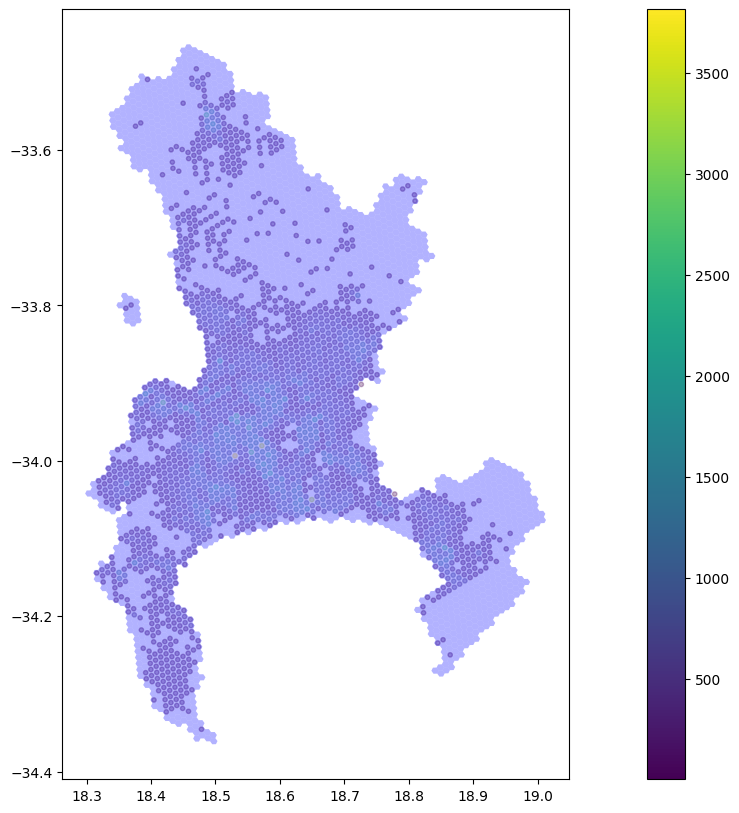

In [172]:
# Plot it to inspect overlaps
fig, ax = plt.subplots(figsize=(20, 10))
gdf_srg.plot(ax=ax, column='cnt', alpha=0.3, legend=True, markersize=10)
gdf_l8_given.plot(ax=ax, color="blue", alpha=0.3)

From this we see that only two aggregated points fall outside of the polygons. We therefore expect no less than 2 join failures.

In [173]:
# Create a geodataframe for the service requests
gdf_sr = gpd.GeoDataFrame(df_sr, geometry=gpd.points_from_xy(df_sr['longitude'], df_sr['latitude']))

# Performing the inner join using the H3 index
gdf_join = gdf_l8_given.merge(gdf_sr, left_on='index', right_on=hex_col, how='inner')


In [174]:
sr_size = gdf_sr.shape[0]
join_size = gdf_join.shape[0]
difference = sr_size - join_size
loss_percentage = difference / sr_size * 100
print(f"Original size {sr_size}, join size {join_size}, difference {difference}, loss percentage {loss_percentage:f}%")

TOLERABLE_JOIN_LOSS_PERCENTAGE = 0.01
assert loss_percentage < TOLERABLE_JOIN_LOSS_PERCENTAGE, f"Join loss percentage {loss_percentage:f}% is higher than the tollerable {TOLERABLE_JOIN_LOSS_PERCENTAGE:f}%"

Original size 729270, join size 729267, difference 3, loss percentage 0.000411%


At the time of this writing, the join loss was 0.000411%. This is a small and can be considered negligible. However I've set the join loss threshold to 0.01% to be safe. This should be more than adequate for detecting:
- programming errors e.g. 
  - swapping latitude and longitude
  - incorrect query parameters
- data capturing error where the coordinates fall outside the administered area.

# 5. Further Data Transformations

In [175]:
# MVP: specify coordinates of interested area manually.
BELVILLE_SOUTH = (-33.916026, 18.644224)
BELVILLE_SOUTH_H3 = h3.geo_to_h3(*BELVILLE_SOUTH, RESOLUTION_LEVEL)
(lat, lng) = h3.h3_to_geo(BELVILLE_SOUTH_H3)

gdf_cent = gpd.GeoDataFrame([{'index': BELVILLE_SOUTH_H3, 'geometry': gpd.points_from_xy([lng], [lat])[0]}])

# edges = h3.get_h3_unidirectional_edges_from_hexagon(BELVILLE_SOUTH_H3)
# h3.
# print(h3.edge_length(h3.get_h3_unidirectional_edge(BELVILLE_SOUTH_H3, edges), unit='km'))


At resolution level 8, the approximate edge length is 500 meters (from https://h3geo.org/docs/core-library/restable/). 

**I'm assuming a the "1 minute distance" is traveling by car at an average of 60 km/h.** So from the centroid, it means we have to find all the polygons at level 9, that overlap as well as intersect our level 8 centroid to cover an apporximate area of **1km radius**. The calculation and plot is shown below.

In [176]:
# Find the level 9 area as described above
# (this is my first time using H3 so I'm sure there are more elegant ways to do this)
centroid_children = h3.h3_to_children(BELVILLE_SOUTH_H3, 9)
level9_area = set()
for child in centroid_children:
    siblings = h3.k_ring(child, 1)
    for sibling in siblings:
        level9_area.add(sibling)

In [177]:
# Reference https://geopandas.org/en/stable/gallery/plotting_with_folium.html
# Plot the area calculated above.
from h3_plot_helper import h3_index_to_geojson, visualize_hexagons

# Plot

level9_area.add(BELVILLE_SOUTH_H3)
m = folium.Map(location=[lat, lng], zoom_start=15)
# visualize_hexagons([BELVILLE_SOUTH_H3], folium_map=m )
m.add_child(
    folium.Marker(
        popup="Belville South centroid",
        location=[lat, lng],
    )
)

folium.GeoJson(h3_index_to_geojson(level9_area)).add_to(m)
m

Next find all the service requests that fall within the polygons.


In [178]:
gdf_belville = gdf_join[gdf_join['h3_hex9'].isin(level9_area)]


On this filtered set we round the `creation_timestamp` to the nearest hour


In [179]:
# References
# https://stackoverflow.com/questions/49561989/pandas-rounding-to-nearest-hour
gdf_belville['hour'] = gdf_belville['creation_timestamp'].apply(lambda t: pd.to_datetime(t).round('H')).copy()


/tmp/ipykernel_695401/3441803491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_belville['hour'] = gdf_belville['creation_timestamp'].apply(lambda t: pd.to_datetime(t).round('H')).copy()


In [181]:
wd_bytes = wd_repo.get_bytes()

AttributeError: 'WindDataRepository' object has no attribute 'get_bytes'

In [ ]:

df = pd.read_excel(bytes_data, engine="odf", skiprows=2, header=None)
df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: x if x == x else 'none')
cols = tuple(zip(df.iloc[0], df.iloc[2]))
header = pd.MultiIndex.from_tuples(cols, names=['area', 'metric'])
df.drop([0,1,2], inplace=True)
df.columns = header
return df

In [ ]:
df_wd = wd_repo.get_as_dataframe()


In [ ]:
#df_wd["Date & Time"].filter(lambda x: f"{x}")
#df_wd.set_index("Date & Time", inplace=True)
#k = df_wd["Date & Time"].apply(lambda x: pd.to_datetime(f"{x}", format='%d/%b/%Y %H:%M', errors='ignore'))
#pd.to_datetime(df_wd["Date & Time"], format='%d/%b/%Y %H:%M', errors='ignore')
#df_wd["Date & Time"].
df_wd

area         Date & Time Atlantis AQM Site                    \
metric               NaN               Deg               m/s   
3       01/01/2020 00:00               173               4.1   
4       01/01/2020 01:00             177.7                 4   
5       01/01/2020 02:00             180.7               2.8   
6       01/01/2020 03:00             183.7               2.3   
7       01/01/2020 04:00             170.7               2.4   
...                  ...               ...               ...   
8790             MaxDate  11/01/2020 04:00  17/01/2020 15:00   
8791                 Avg             188.8                 4   
8792                 Num              2324              2324   
8793             Data[%]              26.5              26.5   
8794                 STD                67               1.9   

area   Bellville South AQM Site                   Bothasig AQM Site  \
metric                      Deg               m/s               Deg   
3                           191               2.5             163.7   
4                         209.7               1.6               159   
5                         202.5               1.4             148.8   
6                         224.7               1.2               153   
7                         244.3               1.3             153.4   
...                         ...               ...               ...   
8790           11/12/2020 21:00  13/07/2020 12:00  16/10/2020 23:00   
8791                      216.9                 2             175.5   
8792                       7390              8531              8434   
8793                       84.1              97.1                96   
8794                    No Data               1.1             110.3   

area                     Goodwood AQM Station                    \
metric               m/s                  Deg               m/s   
3                    5.3                247.8              19.2   
4                    5.4                  247              17.9   
5                    5.5                246.4              17.1   
6                    4.7                245.1              15.7   
7                    4.1                249.9              15.8   
...                  ...                  ...               ...   
8790    01/10/2020 13:00     04/05/2020 08:00  09/07/2020 00:00   
8791                 3.6                293.1                14   
8792                8434                 8636              8118   
8793                  96                 98.3              92.4   
8794                 2.2              No Data               9.8   

area   Khayelitsha AQM Site                   Somerset West AQM Site  \
metric                  Deg               m/s                    Deg   
3                      34.2               1.3                    135   
4                      34.9               1.1                  132.7   
5                      35.5               1.1                  128.5   
6                      35.5                 1                  357.6   
7                      35.1               0.8                  319.5   
...                     ...               ...                    ...   
8790       30/10/2020 01:00  01/10/2020 16:00       01/01/2020 03:00   
8791                   38.1               0.7                  176.9   
8792                   7451              7451                    842   
8793                   84.8              84.8                    9.6   
8794                   12.1               0.4                  102.5   

area                     Tableview AQM Site                    
metric               m/s                Deg               m/s  
3                    3.8              179.8               5.2  
4                    2.1              177.9               5.2  
5                    2.4              167.8                 4  
6                    1.1              177.3               4.4  
7                    1.4              178.7       

In [ ]:
df_wd_bellville = df_wd["Bellville South AQM Site"]
#df_wd_bellville
df_wd_bellville

metric,Deg,m/s
3,191,2.5
4,209.7,1.6
5,202.5,1.4
6,224.7,1.2
7,244.3,1.3
...,...,...
8790,11/12/2020 21:00,13/07/2020 12:00
8791,216.9,2
8792,7390,8531
8793,84.1,97.1
